In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp

import pysindy as ps

import os

# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Seed the random number generators for reproducibility
np.random.seed(100)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

In [2]:
def testscore(predtmp,oritmp):
    score=1
    pred=np.ravel(predtmp)
    ori=np.ravel(oritmp)
    if(len(pred)!=len(ori)):
        print('len not match')
        return 1
    n=0
    for i in range(len(pred)):
        if ori[i]!=0:
            n=n+1
    #print(n)
    for i in range(len(pred)):
        if ori[i]!=0:
            score=score-1/n*abs(pred[i]-ori[i])/abs(ori[i])
            #print(abs(pred[i]-ori[i])/abs(ori[i]))
    print('score:')
    print(score)
    return score

In [3]:

file_path = os.path.join('D:\\', 'hotaidata','sr_C1_20')
x=[]
y=[]
vx=[]
vy=[]
isvalid=[]
xtmp=[]
ytmp=[]
vxtmp=[]
vytmp=[]
isvalidtmp=[]
for root,dirs,files in os.walk(file_path):
    #print(root)
    
    for dir in dirs:
        #print(os.path.join(root,file))

            with open(os.path.join(root,dir,'B00001.dat'), 'r') as f:  
                lines = f.readlines()
                for line in lines[3:]: 
                    num=line.split()
                    xtmp.append(float(num[0]))
                    ytmp.append(float(num[1]))
                    vxtmp.append(float(num[2]))
                    vytmp.append(float(num[3]))
                    isvalidtmp.append(float(num[4]))

            x.append(np.array(xtmp).reshape(25,25))
            y.append(np.array(ytmp).reshape(25,25))
            vx.append(np.array(vxtmp).reshape(25,25))
            vy.append(np.array(vytmp).reshape(25,25))
            isvalid.append(np.array(isvalidtmp).reshape(25,25))
            xtmp=[]
            ytmp=[]
            vxtmp=[]
            vytmp=[]
            isvalidtmp=[]
#
x=np.array(x)
y=np.array(y)
vx=np.array(vx)
vy=np.array(vy)
isvalid=np.array(isvalid)

x=x.T
y=y.T
vx=vx.T
vy=vy.T
#print(x[0,:,:])
t=np.linspace(0,60/800,121)
dt=0.00002

t=t[80:120]
print(len(t))
t_train=np.linspace(t[0],t[-1],len(t)*2-1)
dt_train=t_train[1]-t_train[0]
print(t_train.shape)

40
(79,)


In [4]:
#u is not pre adding, v add a median
spatial_grid = np.asarray([x[:,:,0].T,y[:,:,0].T]).T

n=25

u=np.zeros((n,n,121, 2))

u[:, :, :, 0] = vx
u[:, :, :, 1] = vy
u_train=np.zeros((n,n,len(t_train), 2))
save=np.zeros((n,n,len(t_train), 2))
u_train=u[:,:,80:120,:]
save=u[:,:,80:120,:]

v_train=np.zeros((n,n,len(t_train),2))
for i in range(len(t)-1):
    v_train[:,:,2*i]=u_train[:,:,i]
    v_train[:,:,2*i+1]=(u_train[:,:,i]+u_train[:,:,i+1])/2
v_train[:,:,-1]=u_train[:,:,-1]


In [5]:
v_train_dot = ps.FiniteDifference(axis=2)._differentiate(v_train, dt_train)

vtmp=np.zeros(v_train_dot.shape)
vtmp[:,:,0]=v_train[:,:,0]
for i in range(len(t_train)-1):
    vtmp[:,:,i+1]=vtmp[:,:,i]+v_train_dot[:,:,i]*dt_train
testscore(vtmp,v_train)
vtmp=v_train+v_train_dot*dt_train

vtmp[:,:,1:]=vtmp[:,:,:len(t_train)-1]
testscore(vtmp,v_train)

score:
-15.763373667727373
score:
-5.165577966684542


-5.165577966684542

In [6]:
# Define PDE library that is quadratic in u, and
# fourth-order in spatial derivatives of u.
library_functions = [
    lambda y: y,
    lambda x: x * x * x,

    lambda x, y: x * y * y,
    lambda x, y: x * x * y,
]
library_function_names = [
    lambda y: y,
    lambda x: x + x + x,

    lambda x, y: x + y + y,
    lambda x, y: x + x + y,
]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=3,
    spatial_grid=spatial_grid,
    include_bias=True,
    is_uniform=True,
    periodic=True
)


# Again, loop through all the optimizers
#print('STLSQ model: ')
print('v_train')
print(v_train.shape)

'''
print('SINDy')
model = ps.SINDy(feature_names=['Vx','Vy'])

model.fit(u_train, x_dot=u_dot_train)
model.print()
u_dot_stlsq = model.predict(u_train)

'''
print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=50, alpha=1e-5, 
                     normalize_columns=True, max_iter=200)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer,feature_names=['Vx','Vy'])
model.fit(v_train, dt_train)
model.print()
'''
print('SR3 model, L0 norm: ')
optimizer = ps.SR3(threshold=7, max_iter=10000, tol=1e-15, nu=1e2,
                   thresholder='l0', normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer,feature_names=['Vx','Vy'])
model.fit(u_train, t=dt)
model.print()


print('SR3 model, L1 norm: ')
optimizer = ps.SR3(threshold=0.05, max_iter=10000, tol=1e-15,
                   thresholder='l1', normalize_columns=True)

model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train, x_dot=u_dot_train)
model.print()'''

v_train
(25, 25, 79, 2)
STLSQ model: 
(Vx)' = 49.391 1 + 14.442 Vx + 4.377 Vy + -1.033 VxVxVx + -0.653 VyVyVy + -0.901 VxVyVy + 1.135 VxVxVy + 204.049 Vx_2 + 130.880 Vy_2 + 136.393 Vx_22 + 124.547 Vy_22 + 104.843 Vx_222 + 9.721 Vy_222 + 118.732 Vx_1 + -115.379 Vy_1 + -47.750 Vx_12 + -348.005 Vy_12 + -1334.479 Vx_122 + 131.187 Vy_122 + 146.405 Vx_11 + -10.747 Vy_11 + -194.244 Vx_112 + 84.121 Vy_112 + 180.982 Vx_111 + -55.566 Vy_111 + -166.356 VxVx_2 + -68.687 VxVy_2 + -0.168 VyVx_2 + 3.249 VyVy_2 + 4.980 VxVxVxVx_2 + 4.016 VxVxVxVy_2 + 160.206 VyVyVyVx_2 + 8.689 VyVyVyVy_2 + -1.325 VxVyVyVx_2 + 2.544 VxVyVyVy_2 + -5.476 VxVxVyVx_2 + -8.048 VxVxVyVy_2 + -18.195 VxVx_22 + -300.646 VxVy_22 + 0.236 VyVx_22 + 4.598 VyVy_22 + -0.947 VxVxVxVx_22 + 1.073 VxVxVxVy_22 + 350.994 VyVyVyVx_22 + 73.578 VyVyVyVy_22 + -2.084 VxVyVyVx_22 + -0.478 VxVyVyVy_22 + -5.659 VxVxVyVx_22 + -5.990 VxVxVyVy_22 + -439.848 VxVx_222 + 376.819 VxVy_222 + -11.277 VyVx_222 + 30.616 VyVy_222 + -2.350 VxVxVxVx_222 + 22.86

"\nprint('SR3 model, L0 norm: ')\noptimizer = ps.SR3(threshold=7, max_iter=10000, tol=1e-15, nu=1e2,\n                   thresholder='l0', normalize_columns=True)\nmodel = ps.SINDy(feature_library=pde_lib, optimizer=optimizer,feature_names=['Vx','Vy'])\nmodel.fit(u_train, t=dt)\nmodel.print()\n\n\nprint('SR3 model, L1 norm: ')\noptimizer = ps.SR3(threshold=0.05, max_iter=10000, tol=1e-15,\n                   thresholder='l1', normalize_columns=True)\n\nmodel = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)\nmodel.fit(u_train, x_dot=u_dot_train)\nmodel.print()"

In [7]:
print("Model score: %f" % model.score(u_train, t=t))
print("Model score: %f" % model.score(u_train, t=dt))
print("Model score: %f" % model.score(v_train, t=t_train))
print("Model score: %f" % model.score(v_train, t=dt_train))

Model score: 0.029607
Model score: 0.000953
Model score: 0.012501
Model score: 0.012501


In [8]:
x_dot_test_predicted = model.predict(v_train)
tlen=len(t_train)
dot_tmp=np.array(x_dot_test_predicted)
pltpredict=np.zeros((n,n,tlen,2))


In [10]:
pltpredict=v_train+dot_tmp*dt_train
pltpredict[:,:,1:]=pltpredict[:,:,:len(t_train)-1]
testscore(pltpredict,v_train)


score:
-11.71484431948388


-11.71484431948388

0


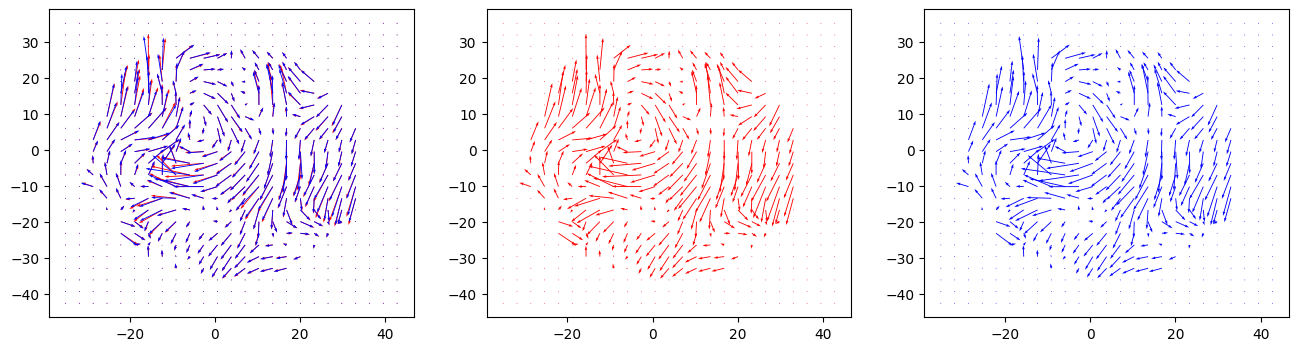

score:
0.7578540064984015
1


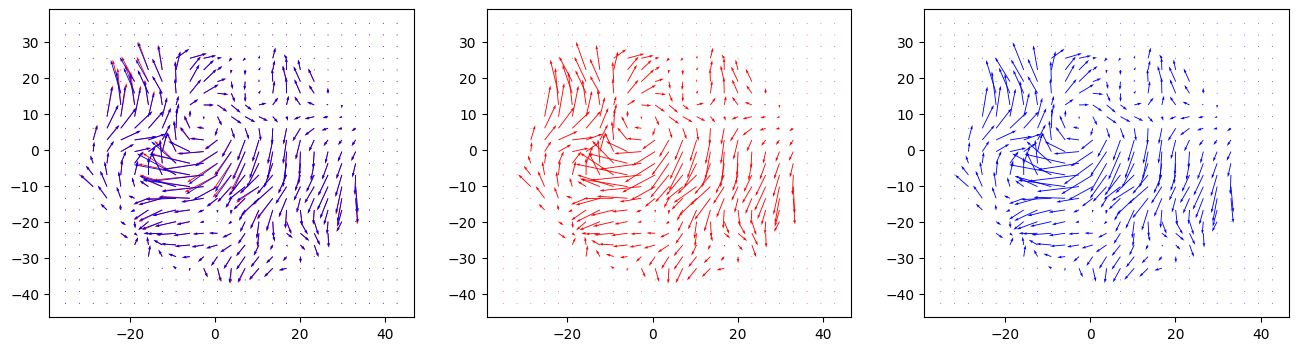

score:
0.8298317293951744
2


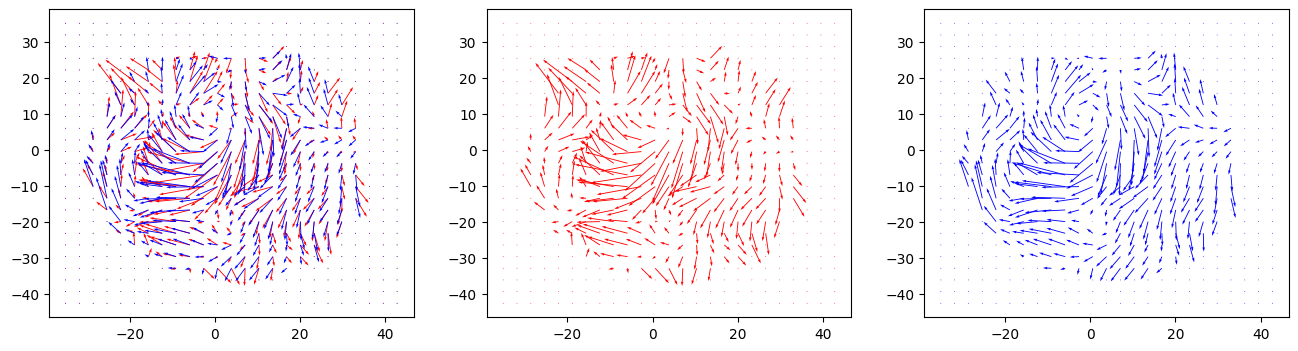

score:
-0.7055227891373204
3


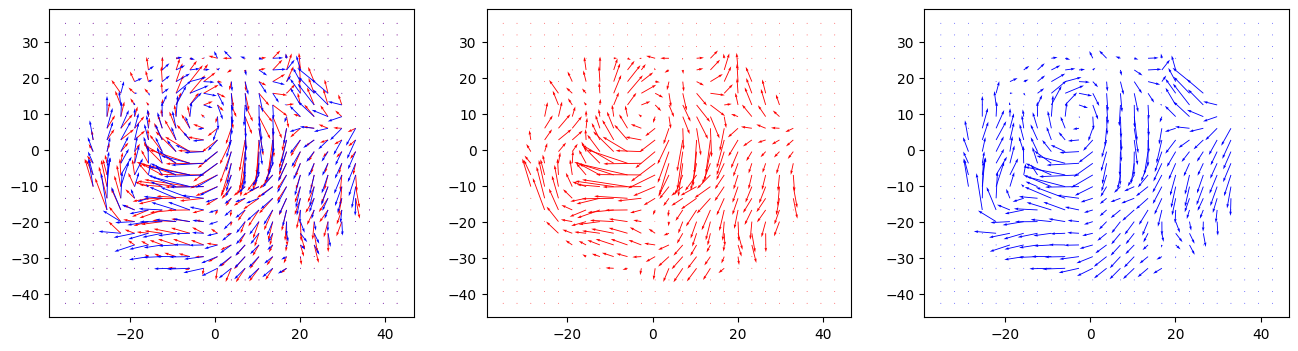

score:
-0.7800524754490741
4


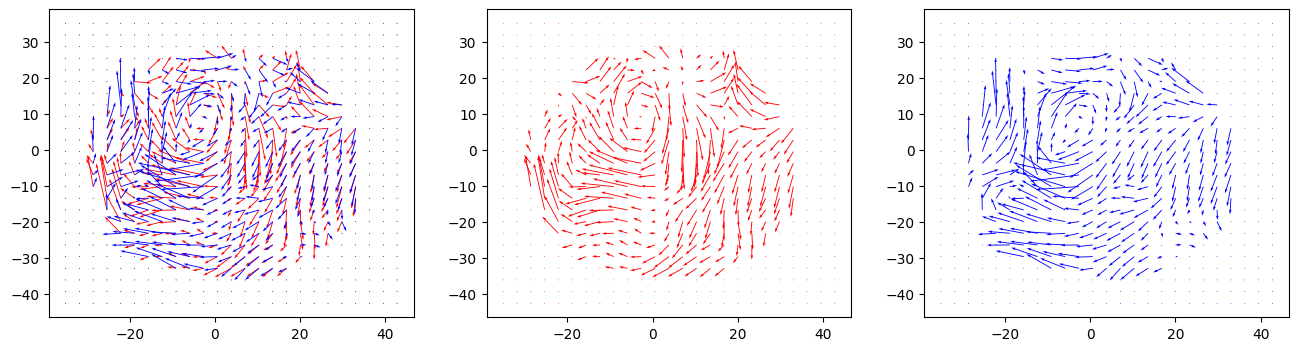

score:
-0.9895826363135319
5


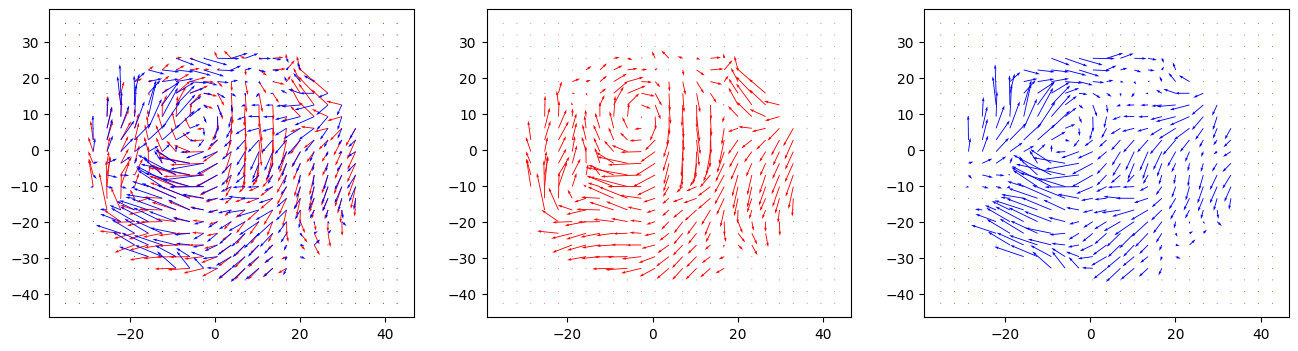

score:
-3.143989422182635
6


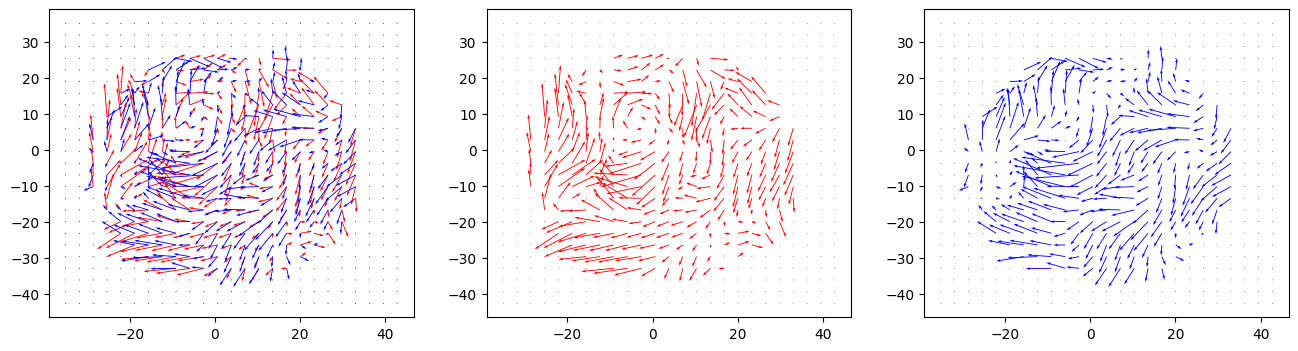

score:
-2.054798792767448
7


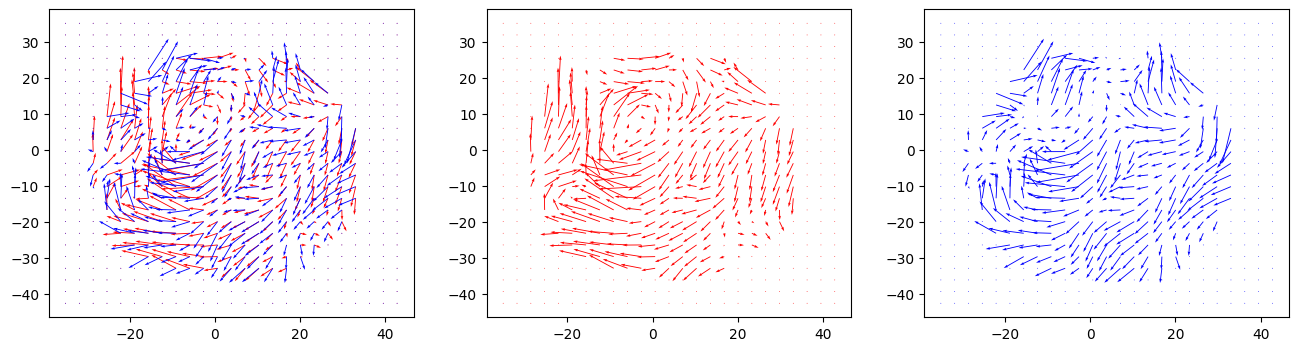

score:
-1.8732561704076653
8


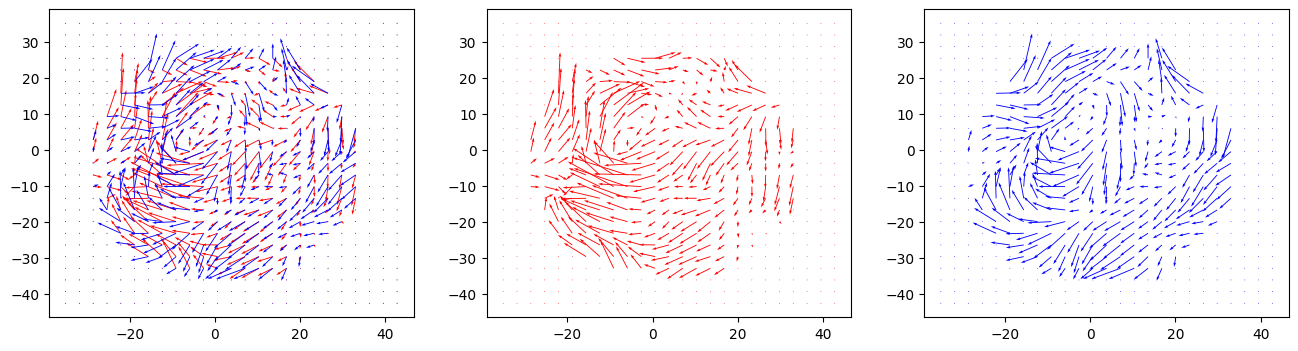

score:
-3.0417930730246576
9


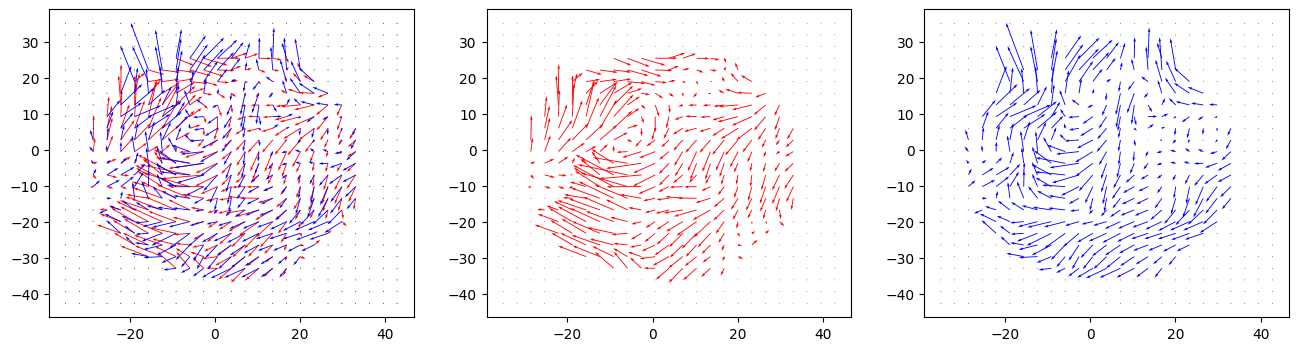

score:
-2.332138842094736
10


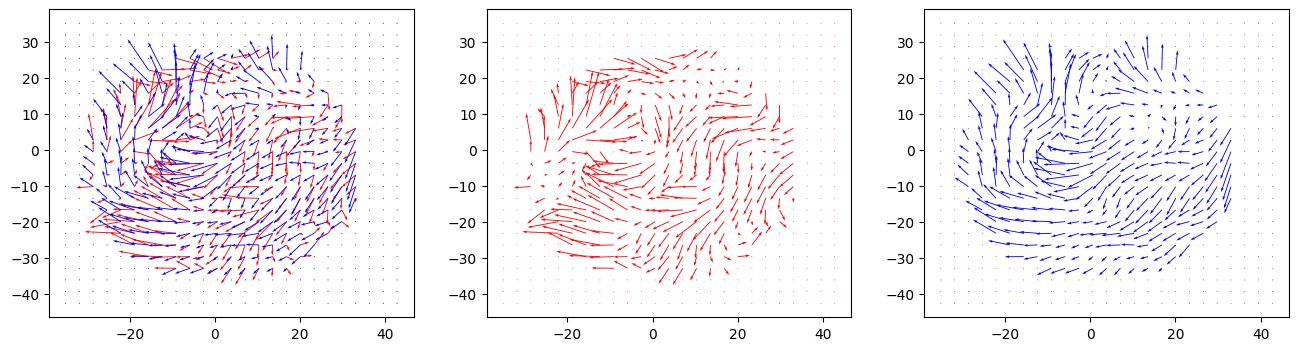

score:
-2.588911477435534
11


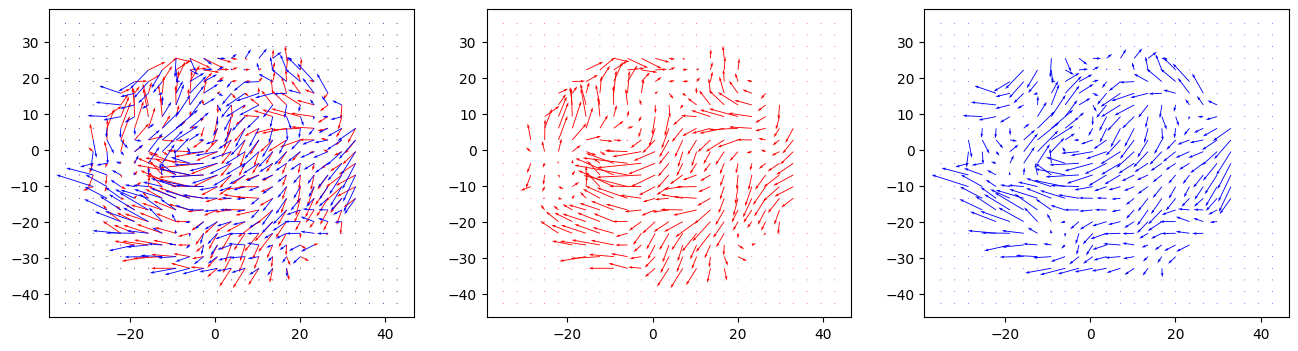

score:
-2.5482094590125315
12


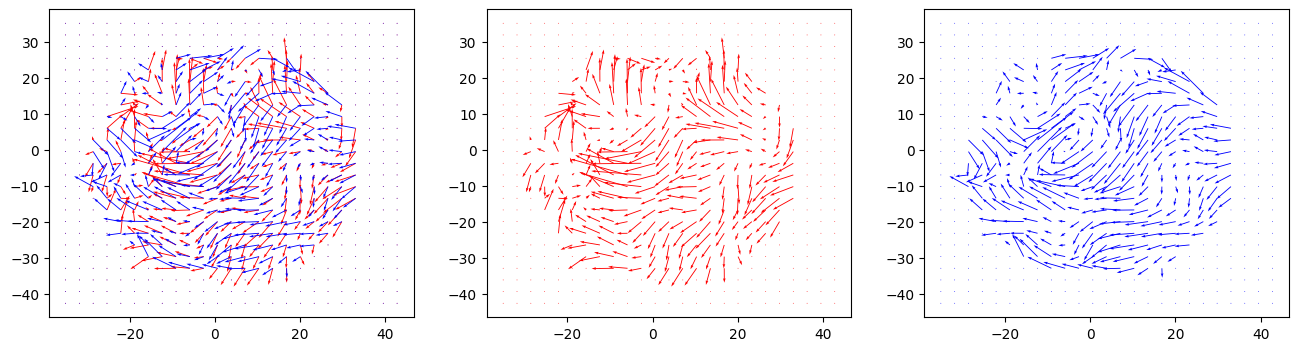

score:
-2.018109193307187
13


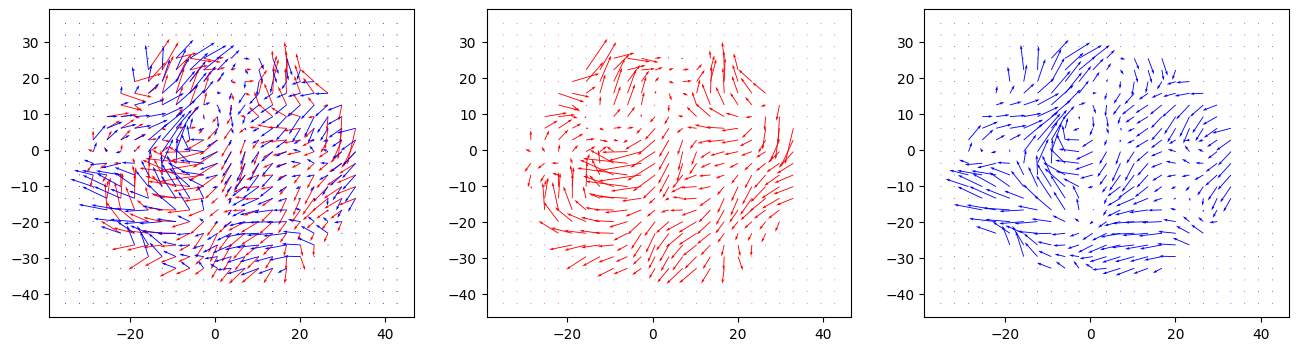

score:
-2.951089039487994
14


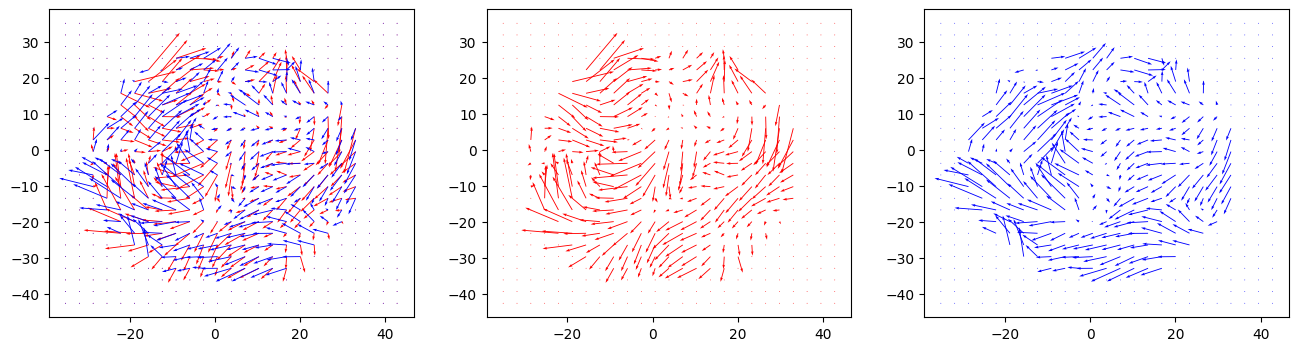

score:
-12.619550712546108
15


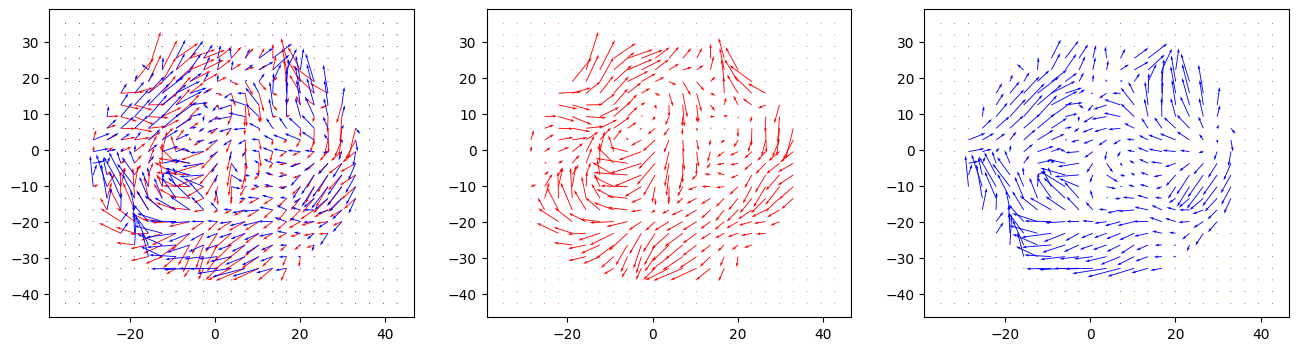

score:
-2.6395657401632286
16


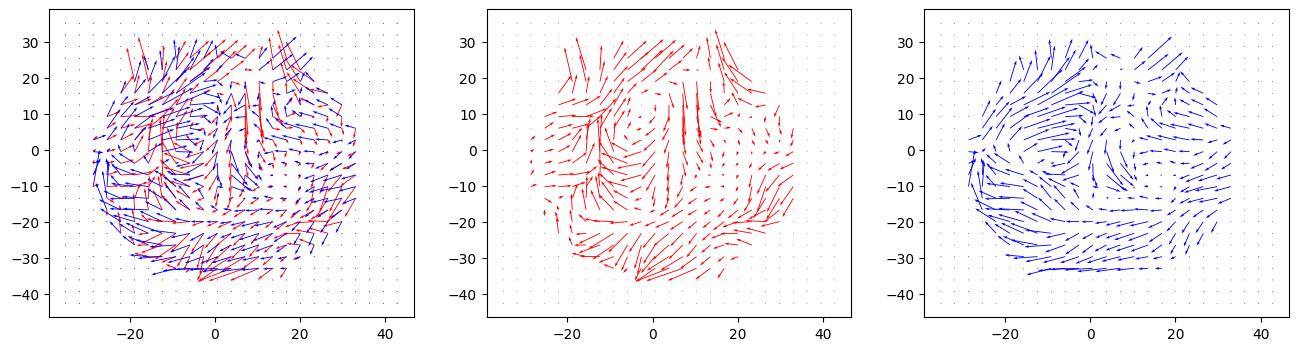

score:
-1.8486743901953133
17


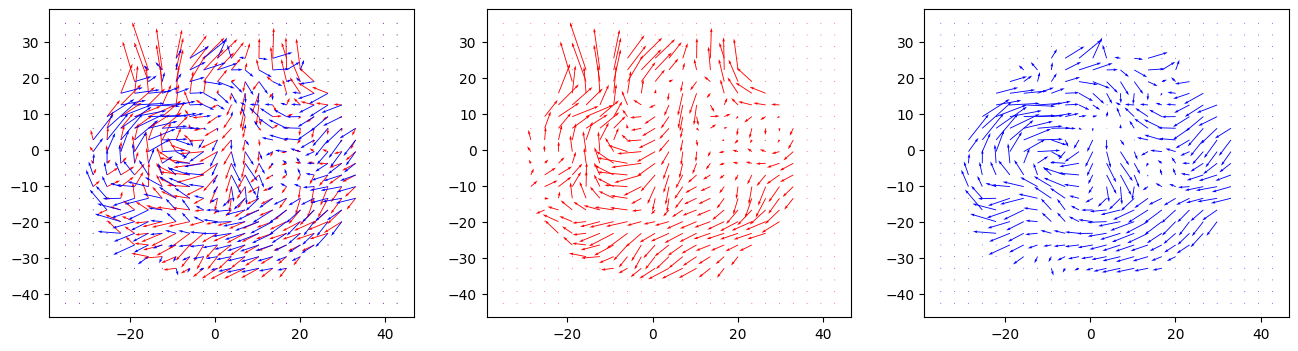

score:
-0.9458409480953524
18


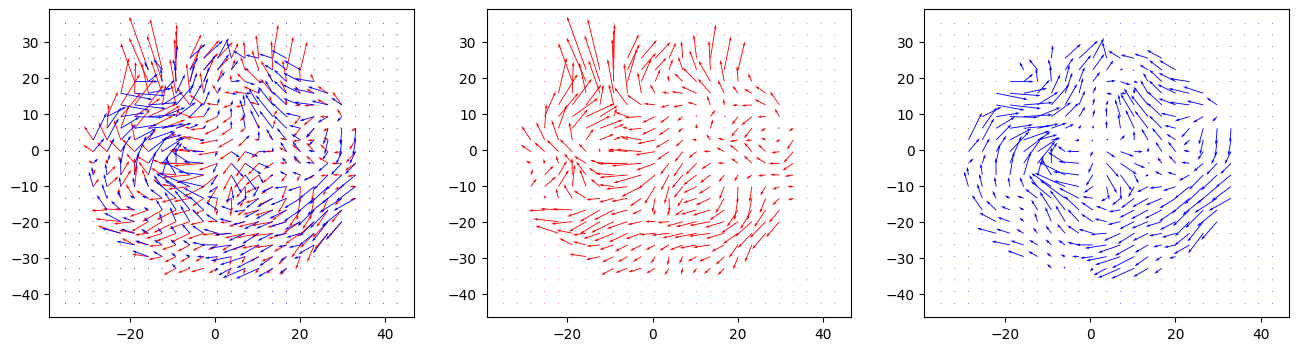

score:
-1.1926924194753996
19


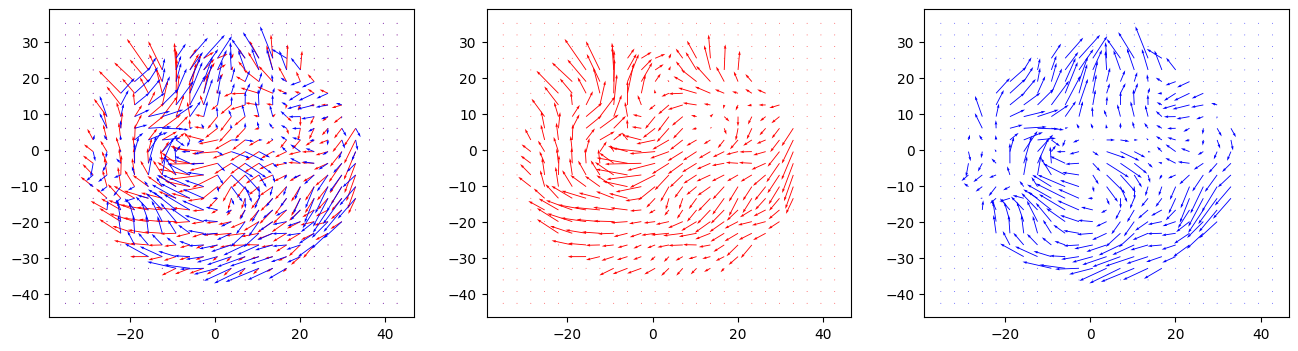

score:
-1.3176541599352822
20


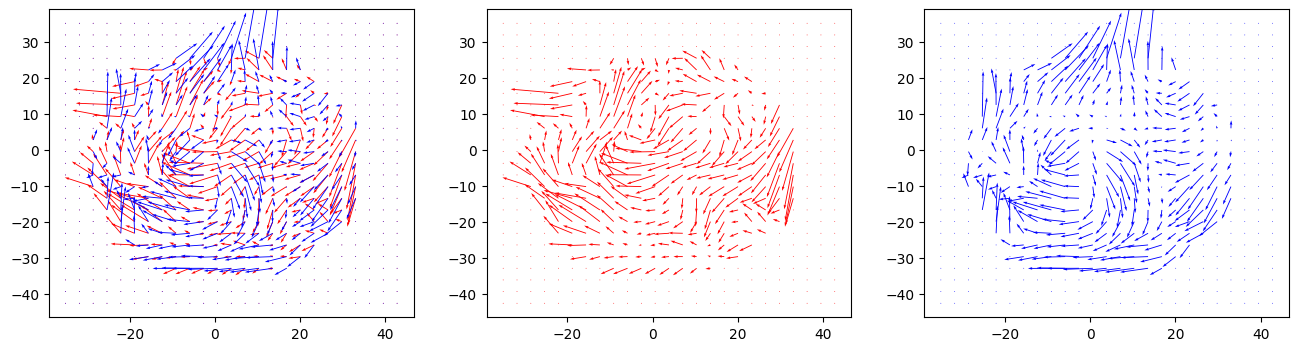

score:
-1.7263245115151278
21


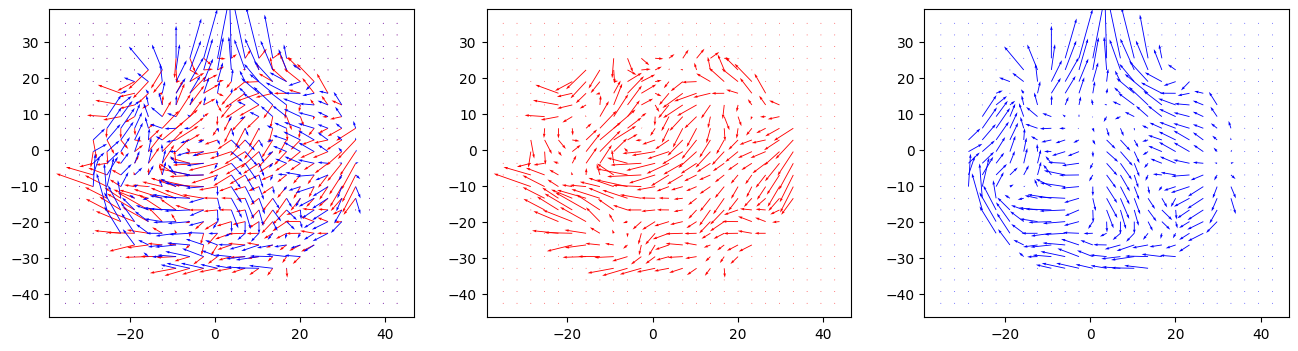

score:
-5.115787550252341
22


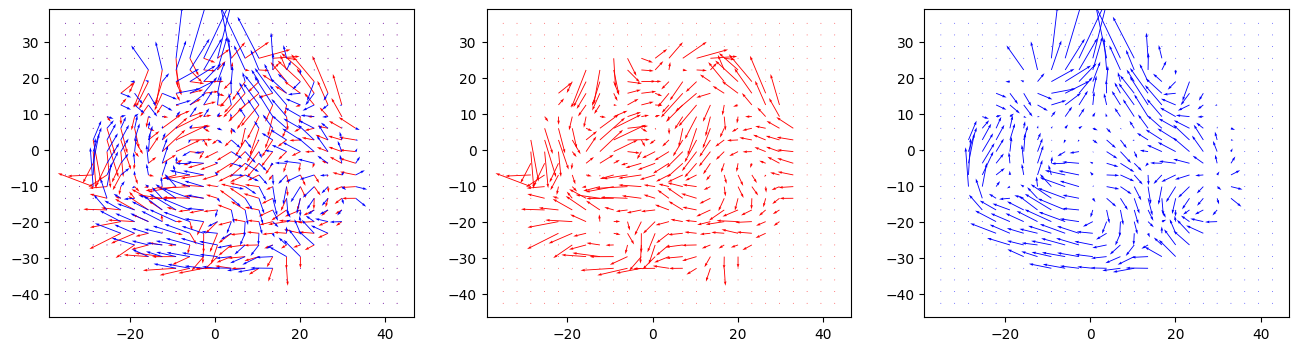

score:
-5.863436321911388
23


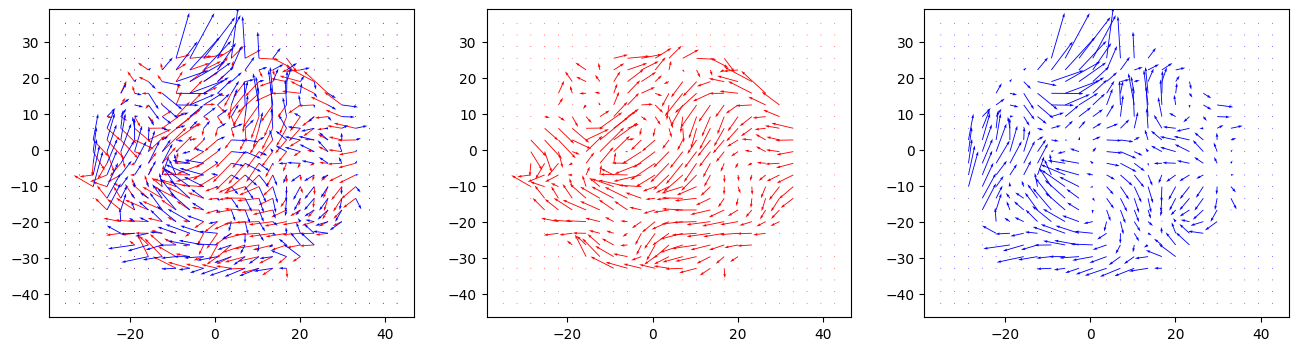

score:
-3.733157479840245
24


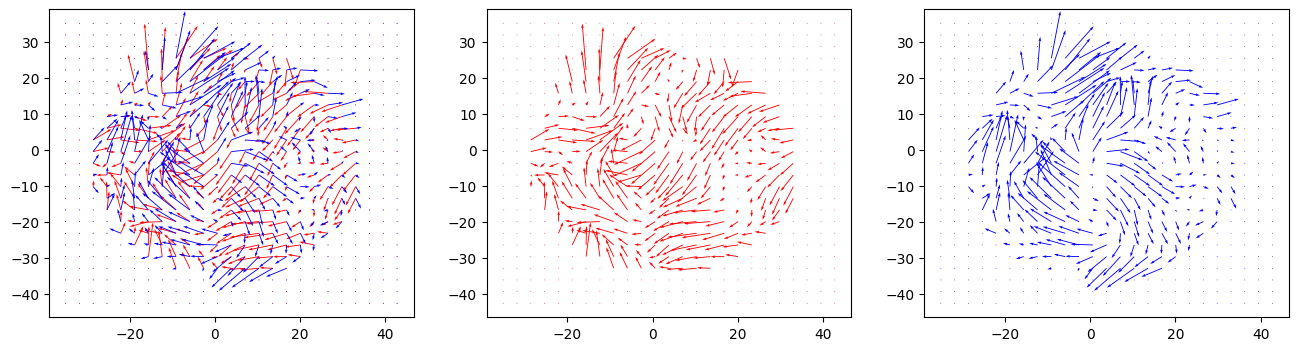

score:
-2.002835767124214
25


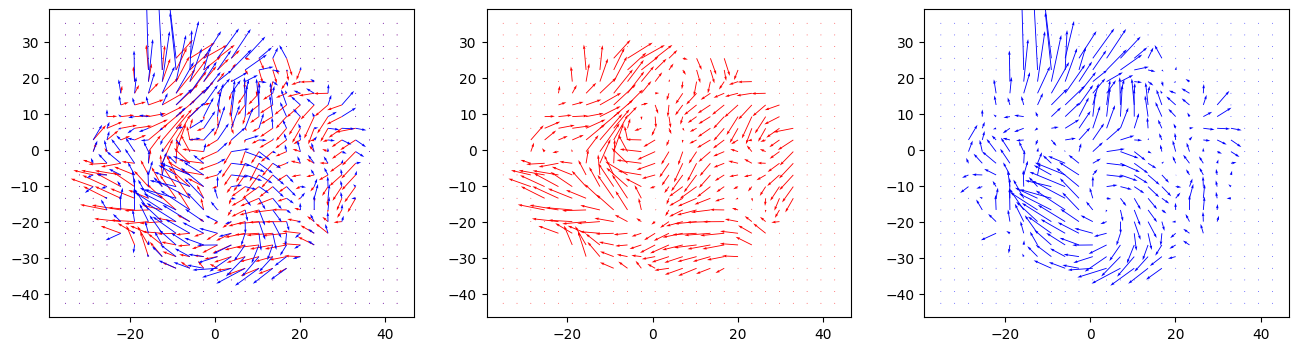

score:
-0.8432382358299912
26


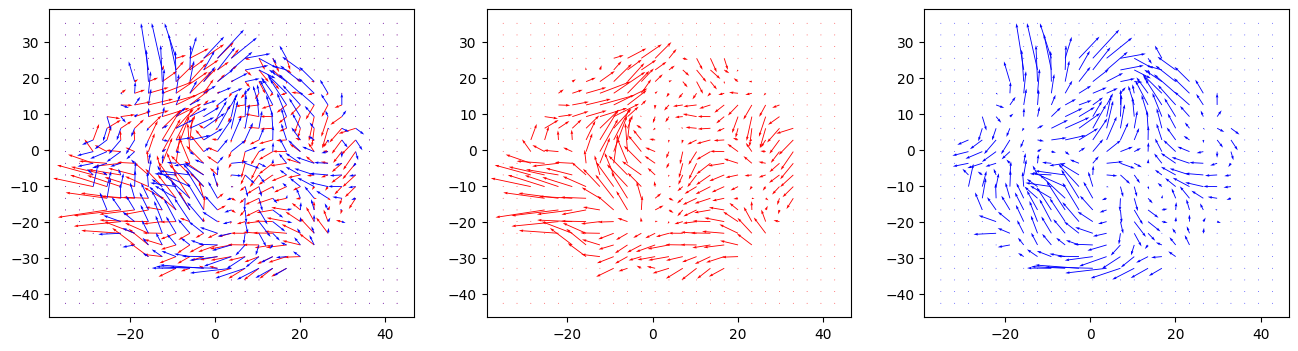

score:
-1.5177284165686322
27


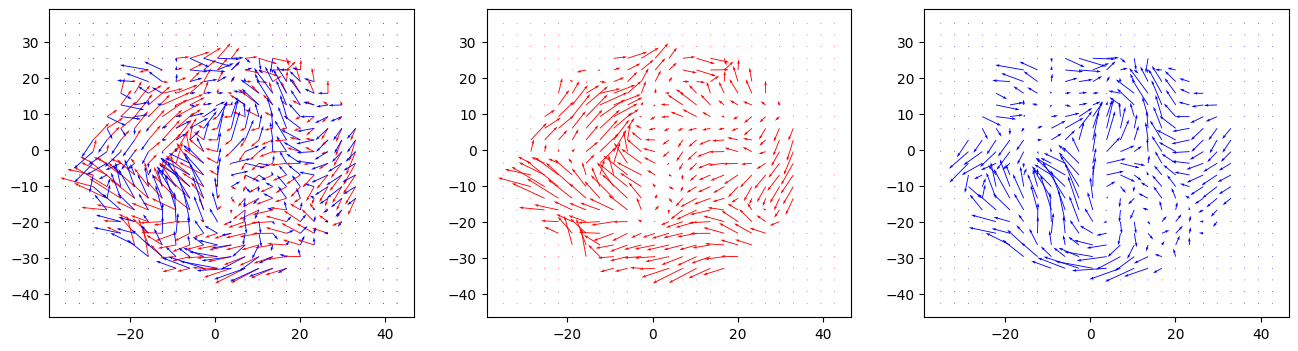

score:
-1.1896775549258185
28


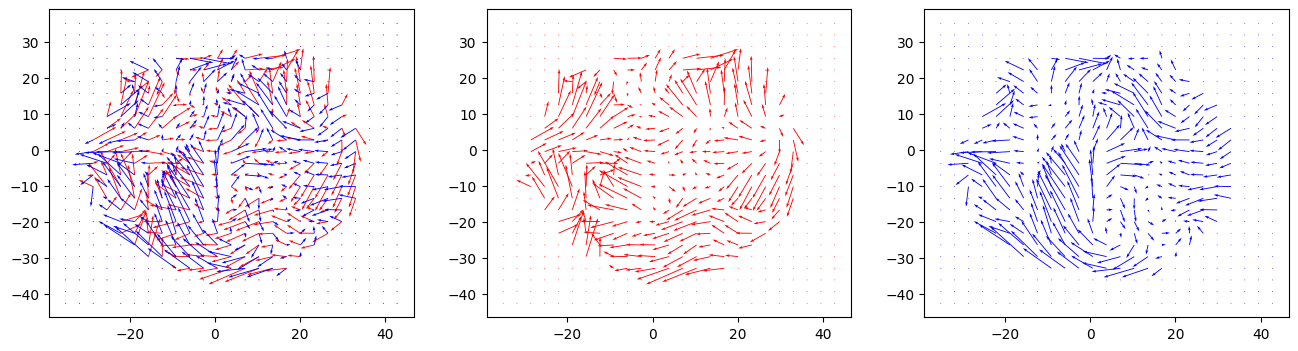

score:
-3.20992167926446
29


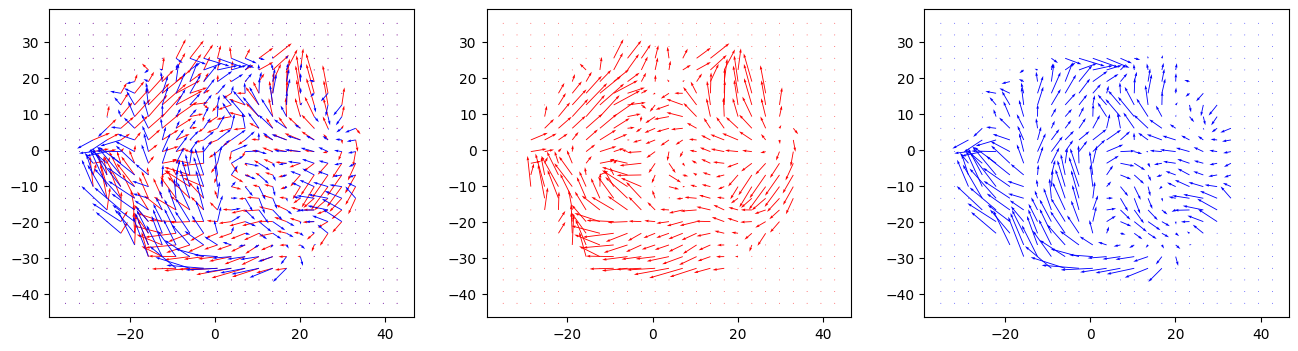

score:
-1.9547534093635148
30


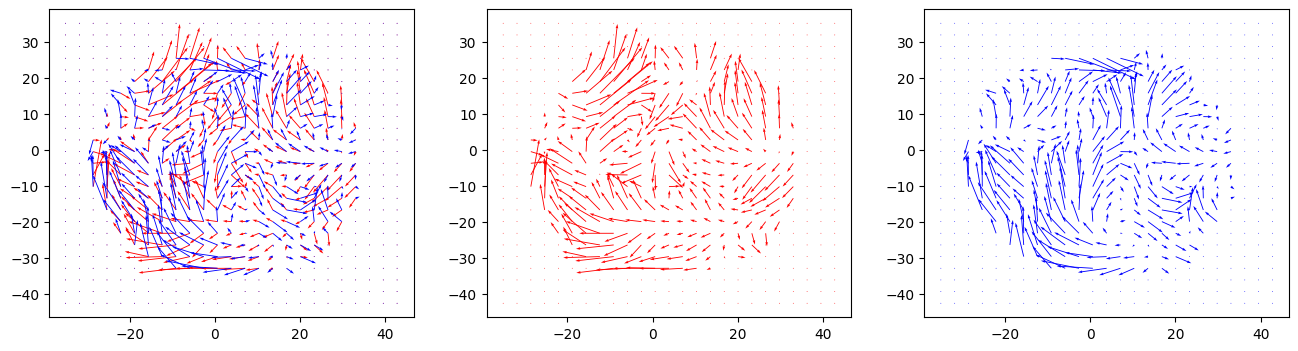

score:
-4.024655140360871
31


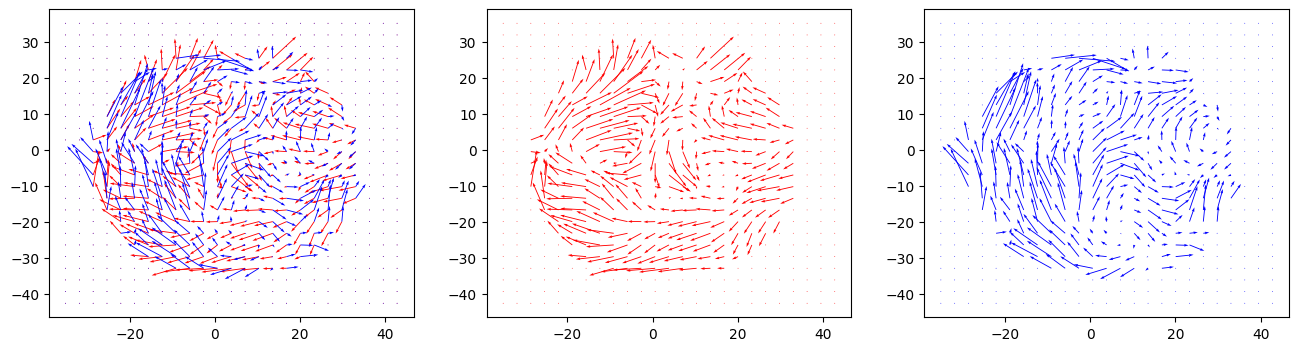

score:
-4.692622466459979
32


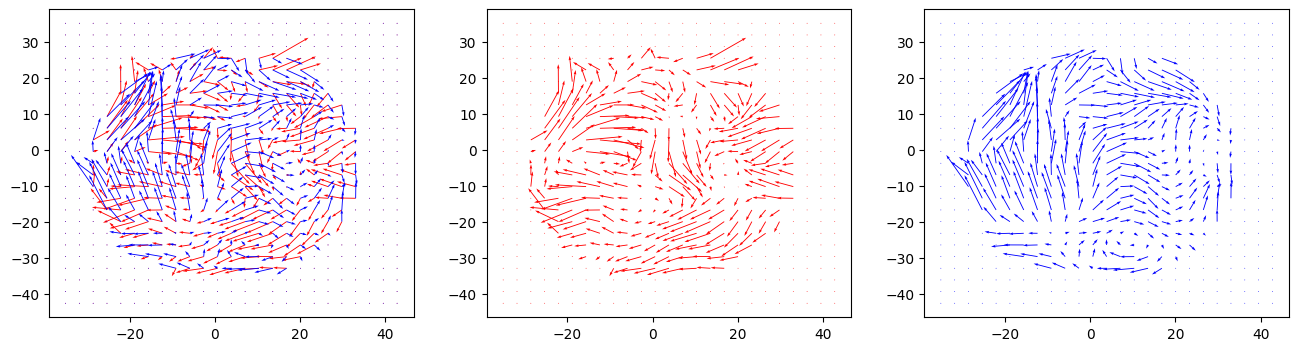

score:
-4.037692985506577
33


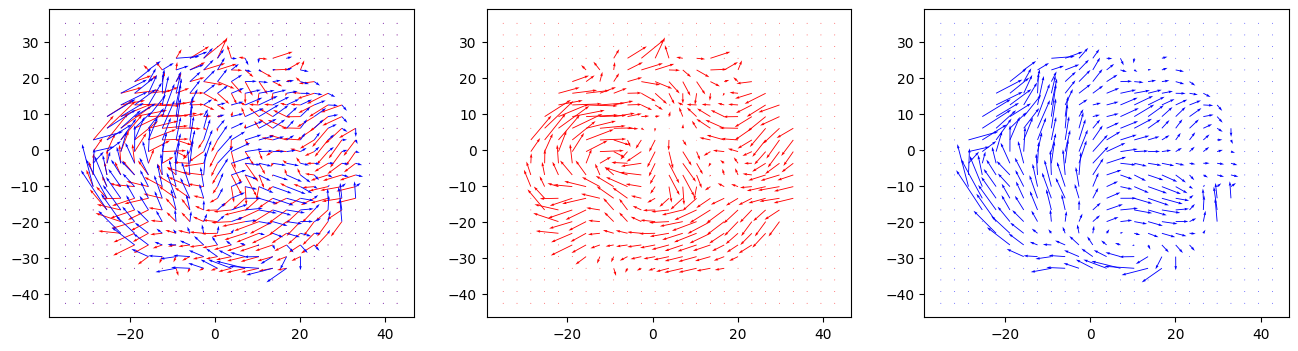

score:
-3.4588198857496106
34


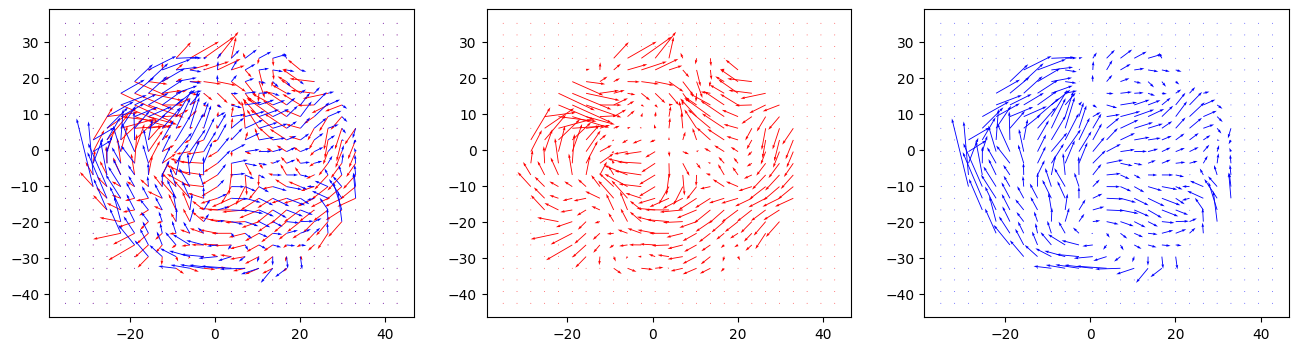

score:
-1.5095205315316704
35


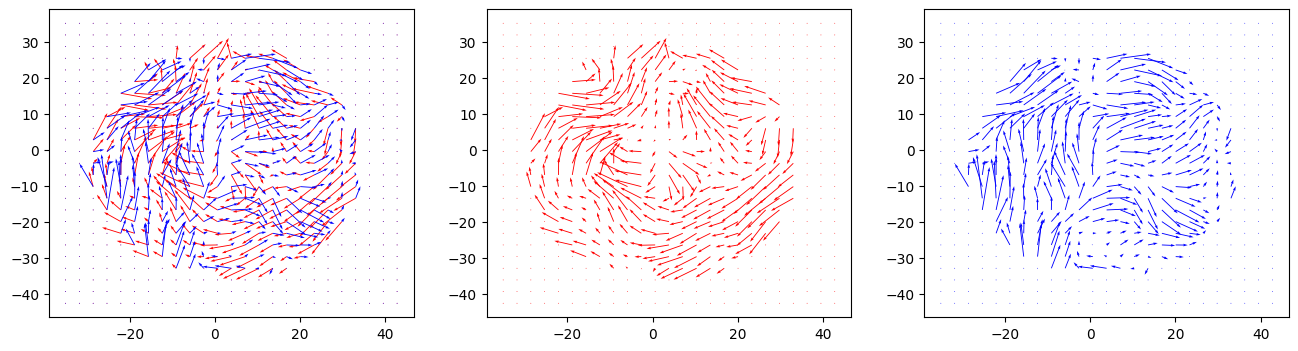

score:
-1.2013964328175764
36


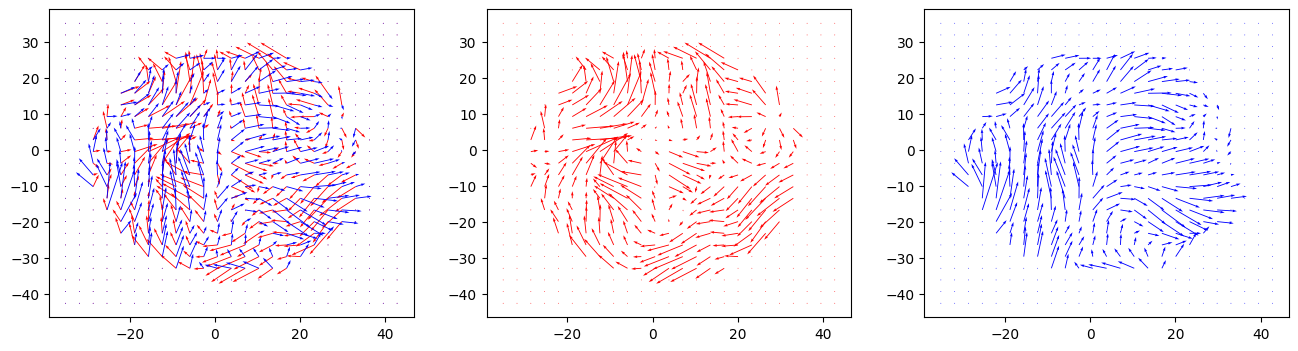

score:
-0.9777290137727794
37


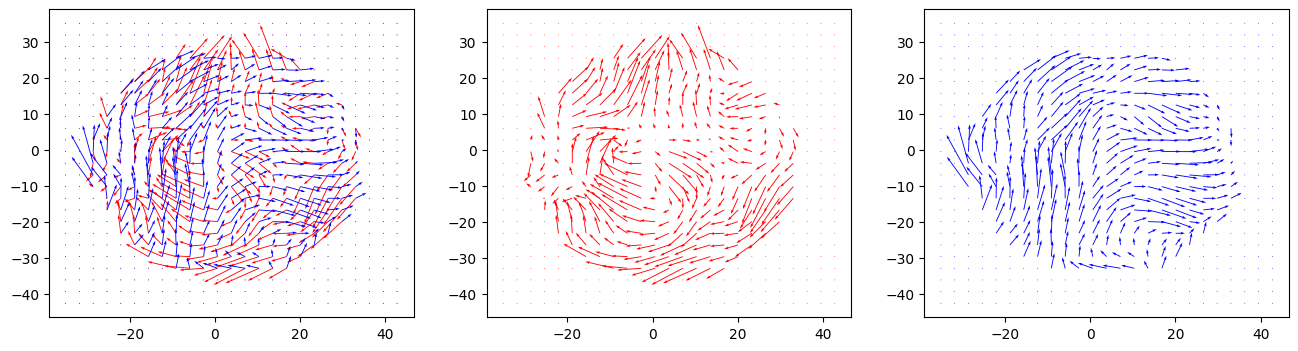

score:
-3553.504340817211
38


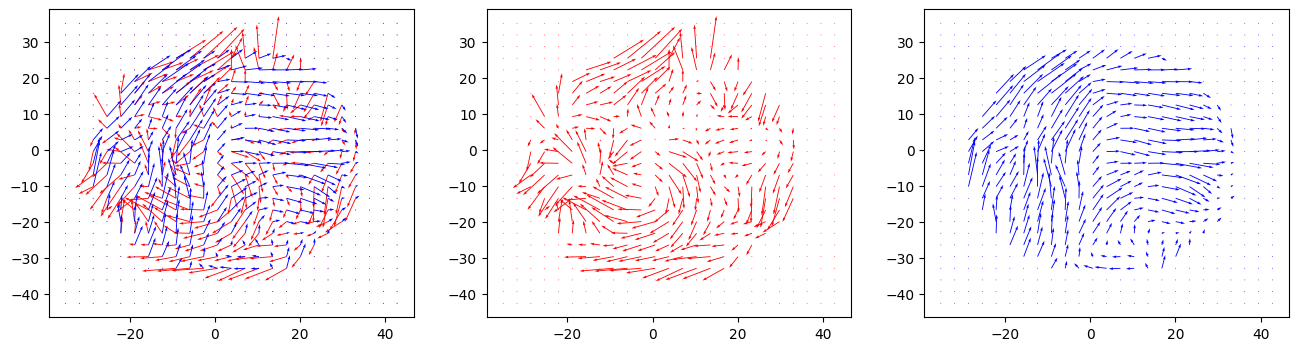

score:
-2.4787702806502026
39


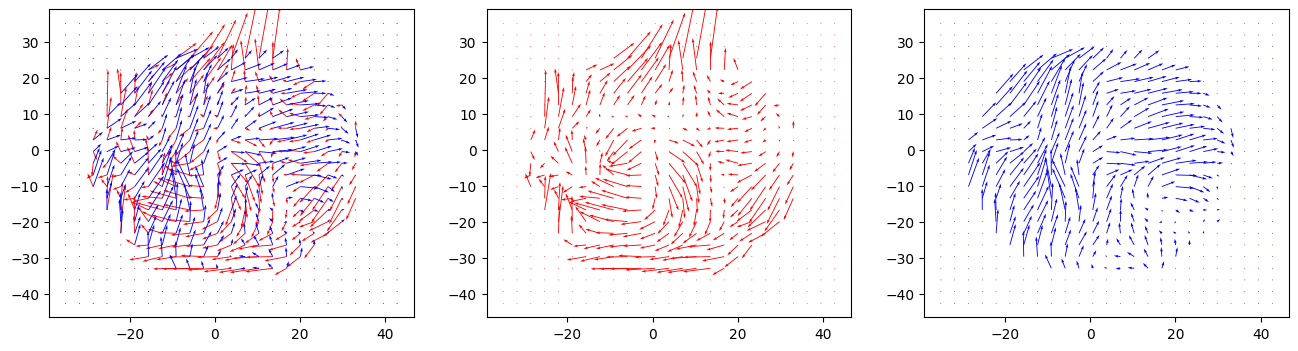

score:
-3.811934794207729


In [11]:
for i in range(40):
    print(i)
    j=i*2
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 3, 1)
    plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],v_train[:,:,i,0],v_train[:,:,i,1],color='r')
    plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],pltpredict[:,:,j,0],pltpredict[:,:,j,1],color='b')
    plt.subplot(1, 3, 2)
    plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],v_train[:,:,i,0],v_train[:,:,i,1],color='r')
    #plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],pltpredict[:,:,i,0],pltpredict[:,:,i,1],color='b')
    plt.subplot(1, 3, 3)
    #plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],u_dot_train[:,:,i+1,0],u_dot_train[:,:,i+1,1],color='r')
    plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],pltpredict[:,:,j,0],pltpredict[:,:,j,1],color='b')
    plt.show()
    testscore(pltpredict[:,:,j,],v_train[:,:,i,:])